![alternatvie text](https://www.doc.zuv.fau.de//M/FAU-Logo/01_FAU_Kernmarke/Web/FAU_Kernmarke_Q_RGB_blue.svg)



# Assignment 3: Minimal GAN in PyTorch

Generative adversarial network (GAN) are well-known deep generative models proposed by [Ian Goodfellow](https://www.iangoodfellow.com) that could be used for synthesising data. It consists of two components, a generator (G) network that learns the data distribution and generates new examples and a discriminator (D) network that distinguishes between real and fake examples i.e. examples generated by G. In this assignment, you'll be asked to implement a series of tasks related to GANs using MNIST and Fashion-MNIST datasets. You upload your use a local python editor or python notebook e.g. Jupyter to implement your solution.

Prior to the assignment, it is necessary to install a package manager e.g. [conda](https://docs.conda.io/en/latest/), and [PyTorch](https://pytorch.org) framework.

## 1. Implement GAN in PyTorch


This public github [repository](https://github.com/bazilas/minimal-gan) implements GANs using tensorflow framework to reconstruct samples from MNIST and Fashion-MNIST data The first task is to re-implement the code (gan.py) using PyTorch framework instead. You should report your training performance i.e. train loss as a figure and another figure containing a batch of generated images after training.

In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.gridspec as gridspec
import os
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from datetime import datetime
from glob import glob
import matplotlib.image as mpimg
import json

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Image Transformation during loading
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
dataset_mnist = datasets.MNIST(root="dataset/", train=True, transform=transform, download=True)

In [2]:
# Models
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.fc1 = nn.Sequential(
            nn.Linear(zdim, 256),
            nn.BatchNorm1d(256),
            nn.ReLU()
        )
        self.fc2 = nn.Sequential(
            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.ReLU()
        )
        self.fc3 = nn.Sequential(
            nn.Linear(512, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU()
        )
        self.fc4 = nn.Sequential(
            nn.Linear(1024, 784),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        x = self.fc4(x)
        return x

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.fc1 = nn.Sequential(
            nn.Linear(784, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.fc2 = nn.Sequential(
            nn.Linear(256, 128),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.fc3 = nn.Linear(128, 1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.fc2(x)
        logit = self.fc3(x)
        return logit


# Sample generation
def draw_sample(m, n):
    return np.random.uniform(-1.0, 1.0, size=[m, n])

# Initialize models, loss function, and optimizers
def initialize_models_and_optimizers(lrd=0.0001, lrg=0.0002, betas=(0.5, 0.999)):
    G = Generator().to(device)
    D = Discriminator().to(device)
    criterion = nn.BCEWithLogitsLoss()
    D_opt = optim.Adam(D.parameters(), lr=lrd, betas=betas)
    G_opt = optim.Adam(G.parameters(), lr=lrg, betas=betas)
    scaler = torch.cuda.amp.GradScaler()  # For mixed precision training
    return G, D, criterion, D_opt, G_opt, scaler

# Train discriminator
def train_discriminator(D, G, D_opt, criterion, imgs, z, scaler):
    with torch.cuda.amp.autocast():
        G_sample = G(z)
        D_real = D(imgs)
        D_fake = D(G_sample)

        D_loss_real = criterion(D_real, torch.ones_like(D_real, device=device))
        D_loss_fake = criterion(D_fake, torch.zeros_like(D_fake, device=device))
        D_loss = D_loss_real + D_loss_fake

    D_opt.zero_grad()
    scaler.scale(D_loss).backward()
    nn.utils.clip_grad_norm_(D.parameters(), max_norm=1.0)
    scaler.step(D_opt)
    scaler.update()

    return D_loss

# Train generator
def train_generator(D, G, G_opt, criterion, z, scaler):
    with torch.cuda.amp.autocast():
        G_sample = G(z)
        D_fake = D(G_sample)
        G_loss = criterion(D_fake, torch.ones_like(D_fake, device=device))

    G_opt.zero_grad()
    scaler.scale(G_loss).backward()
    scaler.step(G_opt)
    scaler.update()

    return G_loss

# Save generated images
def save_generated_images(G, epoch, z, folder_name_for_run, final_image=False, path="res"):
    with torch.no_grad():
        sample = G(z).cpu().numpy()

    fig = plt.figure(figsize=(10, 10))
    gs = gridspec.GridSpec(10, 10)
    for j, sample_img in enumerate(sample):
        ax = plt.subplot(gs[j])
        ax.set_xticks([])
        ax.set_yticks([])
        plt.imshow(sample_img.reshape(28, 28), cmap='Greys_r')

    if not os.path.exists(path):
        os.makedirs(path)

    if not os.path.exists(f'{path}/{folder_name_for_run}'):
        os.makedirs(f'{path}/{folder_name_for_run}')

    if final_image:
        filename = os.path.join(path, f'{folder_name_for_run}/mnist_MGAN_{datetime.now().strftime("%Y%m%d%H%M%S")}_final.png')
    else:
        filename = os.path.join(path, f'{folder_name_for_run}/mnist_MGAN_{datetime.now().strftime("%Y%m%d%H%M%S")}_{str(epoch).zfill(7)}.png')

    plt.savefig(filename, bbox_inches='tight')
    plt.close()

In [4]:
# Hyperparameters
zdim = 100
Nsamples = 256
num_epochs = 200
learning_rate_d = 0.0001
learning_rate_g = 0.0001
betas = (0.5, 0.999)
folder_name_for_run = str(datetime.now().strftime("%Y_%m_%d__%H_%M_%S"))
data_collector = []

hyperparameters = {
    'zdim': zdim,
    'Nsamples': Nsamples,
    'num_epochs': num_epochs,
    'learning_rate_d': learning_rate_d,
    'learning_rate_g': learning_rate_g,
    'betas': betas
}

In [5]:
# load MNIST
dataloader = torch.utils.data.DataLoader(dataset_mnist, batch_size=Nsamples, shuffle=True)

In [6]:
G, D, criterion, D_opt, G_opt, scaler = initialize_models_and_optimizers(lrd=learning_rate_d, lrg=learning_rate_g ,betas=betas)

In [7]:
device

device(type='cuda')

In [8]:
start_time = datetime.now()

for epoch in range(1, num_epochs + 1):
    for i, (imgs, _) in enumerate(dataloader):
        batch_size = imgs.size(0)
        imgs = imgs.view(batch_size, 784).to(device, non_blocking=True)

        # Train discriminator
        z = torch.FloatTensor(draw_sample(batch_size, zdim)).to(device, non_blocking=True)
        D_loss = train_discriminator(D, G, D_opt, criterion, imgs, z, scaler)

        # Train generator more frequently
        for _ in range(2):  # Train generator twice as often
            z = torch.FloatTensor(draw_sample(batch_size, zdim)).to(device, non_blocking=True)
            G_loss = train_generator(D, G, G_opt, criterion, z, scaler)

        data_collector.append({'epoch': epoch, 'step': i, 'D_loss': D_loss.item(), 'G_loss': G_loss.item(), 'hyperparameters': hyperparameters})

        if i % 100 == 0:
            print(f'Epoch [{epoch}/{num_epochs}], Step [{i}/{len(dataloader)}], '
                  f'D Loss: {D_loss.item():.4f}, G Loss: {G_loss.item():.4f}')

    if epoch % 10 == 0:
        print(f'--- Saving images at Epoch [{epoch}] ---')
        z = torch.FloatTensor(draw_sample(100, zdim)).to(device)
        save_generated_images(G, epoch, z, folder_name_for_run)

end_time = datetime.now()
print(f'Training took : {end_time - start_time}')

# Save final generated images
z = torch.FloatTensor(draw_sample(100, zdim)).to(device)
save_generated_images(G, num_epochs, z, folder_name_for_run, final_image=True)

# Save data collector
with open(f'res/{folder_name_for_run}/data_collector.json', 'w') as f:
    json.dump(data_collector, f, indent=4)

Epoch [1/200], Step [0/235], D Loss: 1.3522, G Loss: 0.6640
Epoch [1/200], Step [100/235], D Loss: 1.4079, G Loss: 0.5964
Epoch [1/200], Step [200/235], D Loss: 1.3640, G Loss: 0.6667
Epoch [2/200], Step [0/235], D Loss: 1.3388, G Loss: 0.6888
Epoch [2/200], Step [100/235], D Loss: 1.3929, G Loss: 0.6443
Epoch [2/200], Step [200/235], D Loss: 1.3682, G Loss: 0.6779
Epoch [3/200], Step [0/235], D Loss: 1.4313, G Loss: 0.6290
Epoch [3/200], Step [100/235], D Loss: 1.3766, G Loss: 0.6649
Epoch [3/200], Step [200/235], D Loss: 1.3943, G Loss: 0.6781
Epoch [4/200], Step [0/235], D Loss: 1.4395, G Loss: 0.6333
Epoch [4/200], Step [100/235], D Loss: 1.3727, G Loss: 0.6843
Epoch [4/200], Step [200/235], D Loss: 1.3700, G Loss: 0.6699
Epoch [5/200], Step [0/235], D Loss: 1.3811, G Loss: 0.6795
Epoch [5/200], Step [100/235], D Loss: 1.3616, G Loss: 0.6779
Epoch [5/200], Step [200/235], D Loss: 1.3811, G Loss: 0.6949
Epoch [6/200], Step [0/235], D Loss: 1.3948, G Loss: 0.6907
Epoch [6/200], Step 

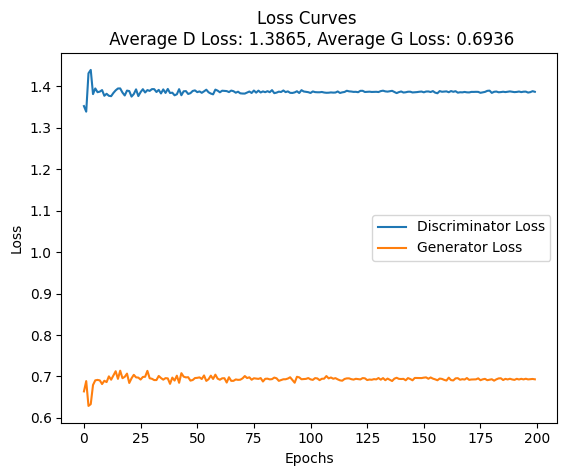

In [10]:
#plot losses
epochs = [entry['epoch'] for entry in data_collector if entry["step"] == 0]
steps = [entry['step'] for entry in data_collector if entry["step"] == 0]
D_losses = [entry['D_loss'] for entry in data_collector if entry["step"] == 0]
G_losses = [entry['G_loss'] for entry in data_collector if entry["step"] == 0]

fig, ax = plt.subplots()
ax.plot(range(len(D_losses)), D_losses, label='Discriminator Loss')
ax.plot(range(len(G_losses)), G_losses, label='Generator Loss')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.legend()
plt.title(f'Loss Curves \n Average D Loss: {np.mean(D_losses):.4f}, Average G Loss: {np.mean(G_losses):.4f}')
plt.show()

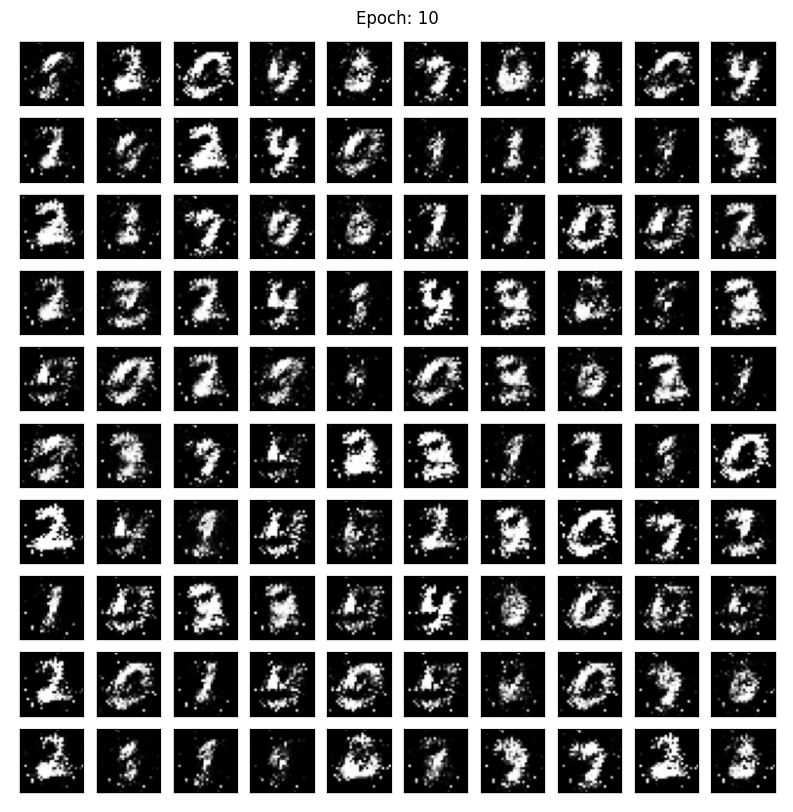

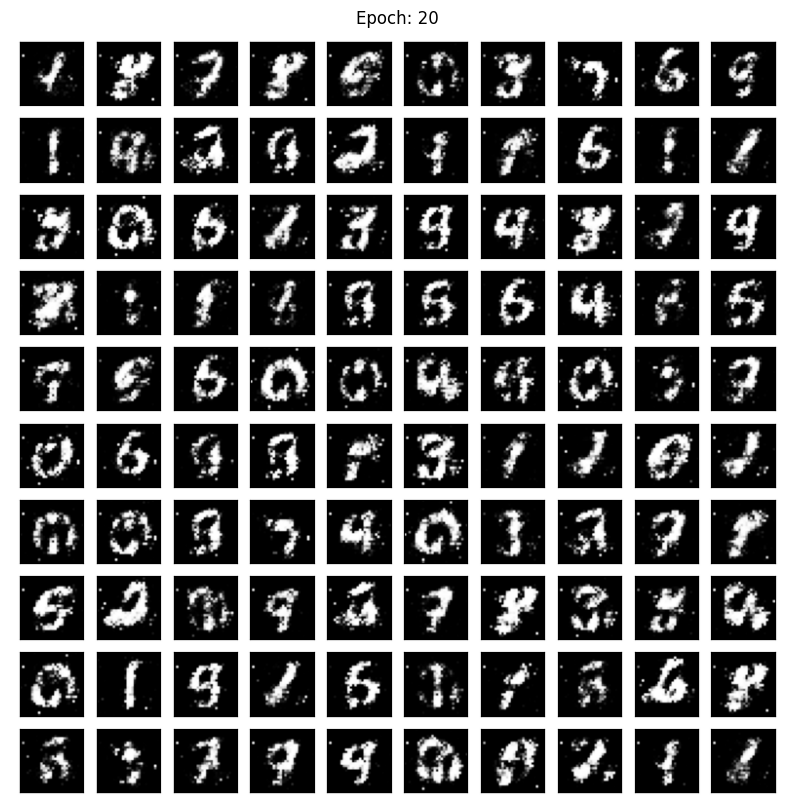

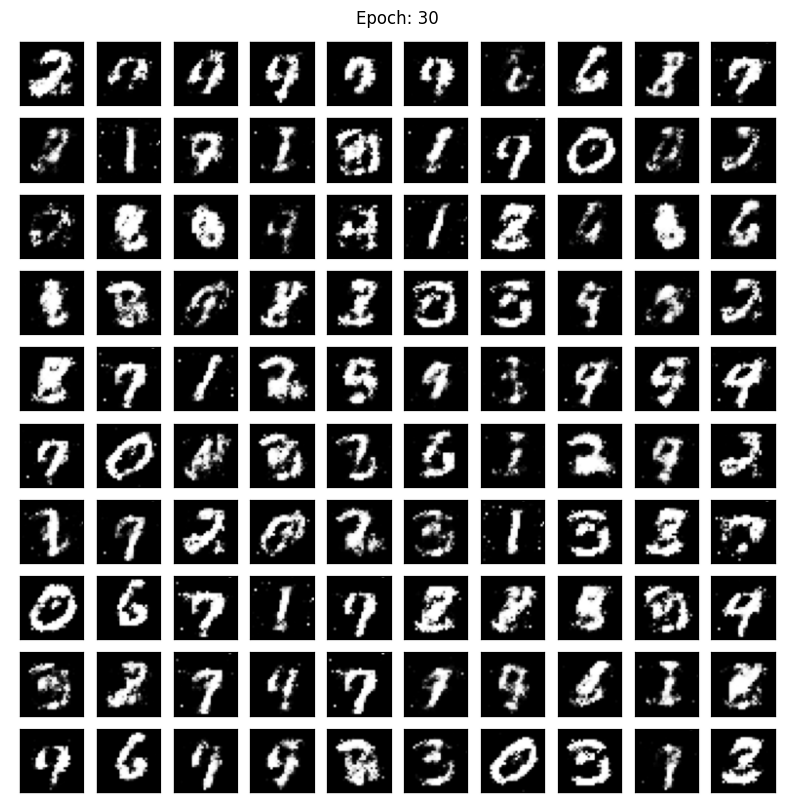

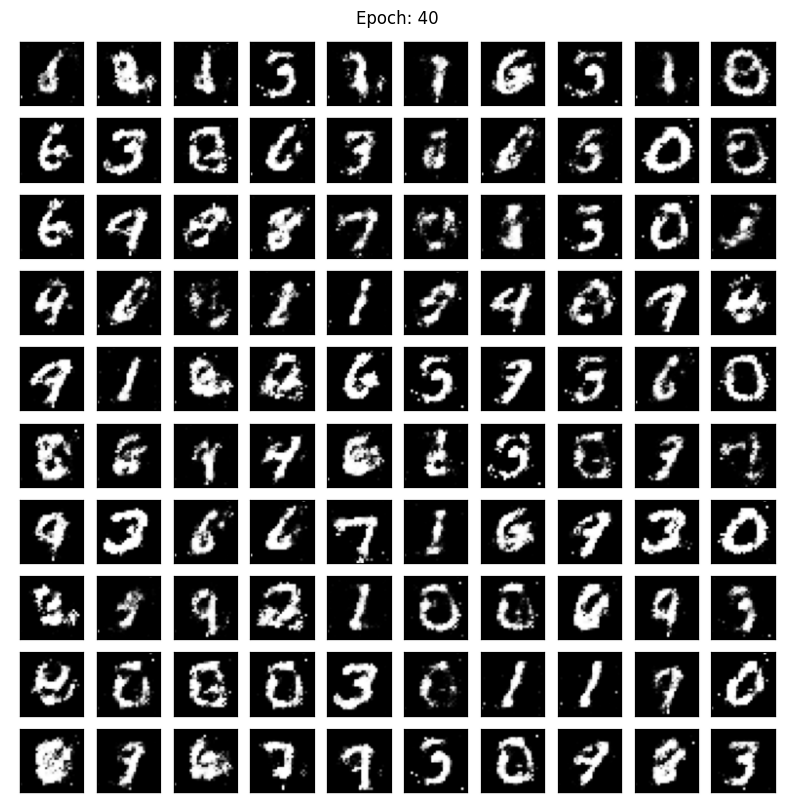

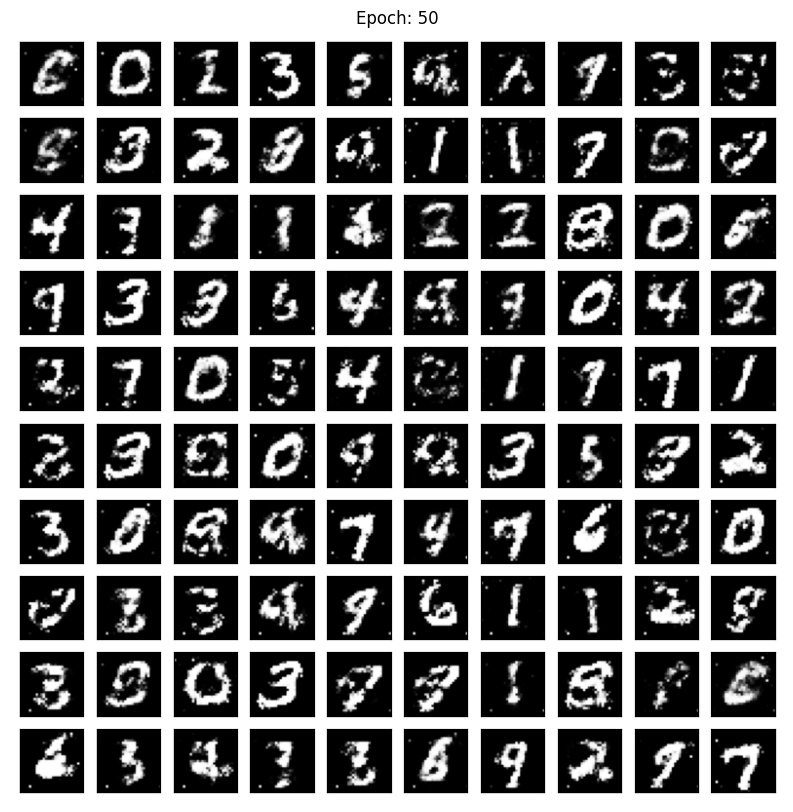

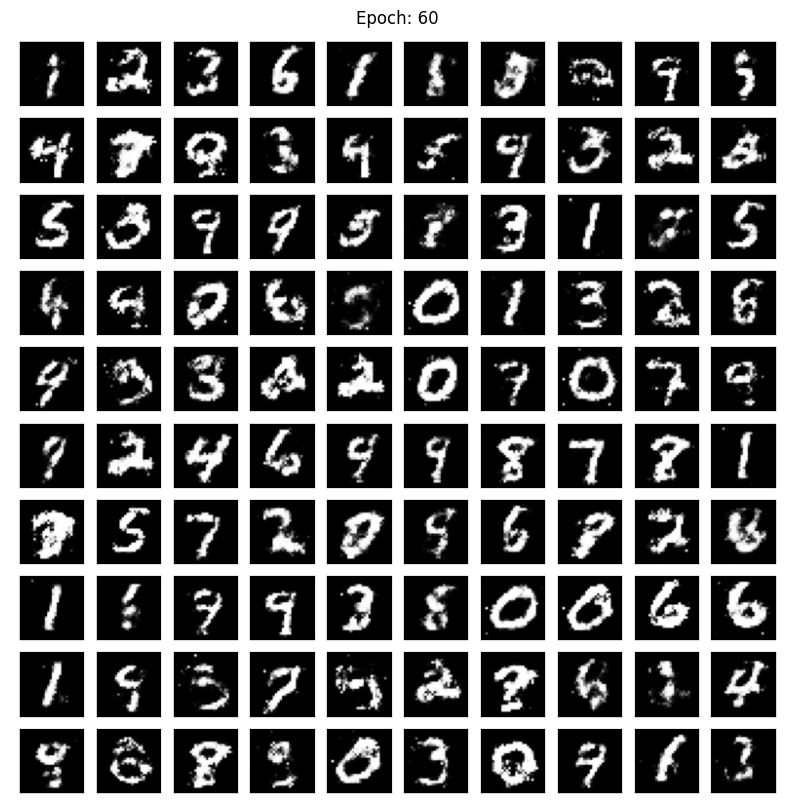

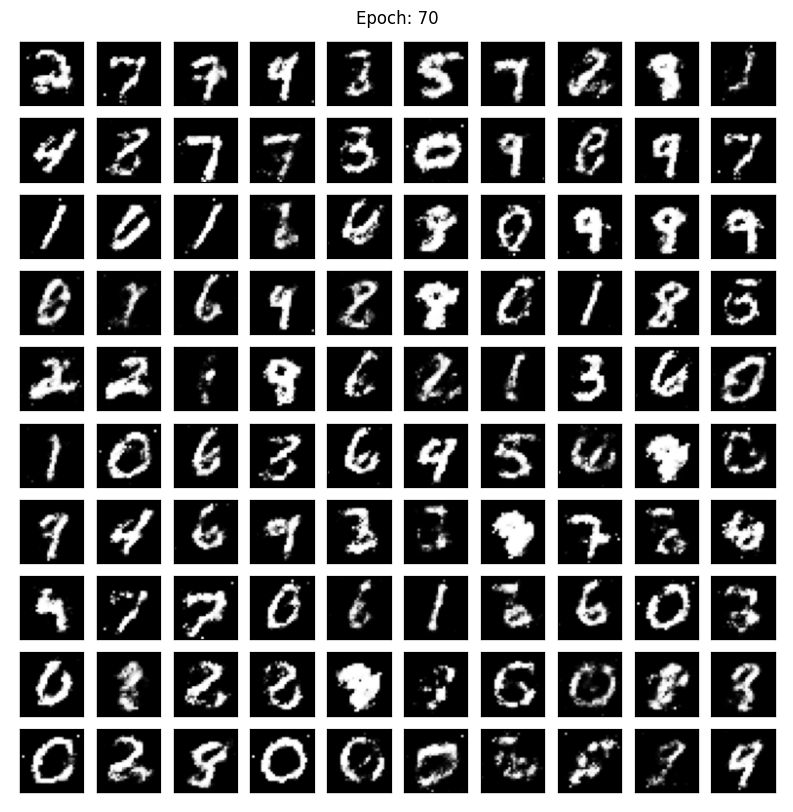

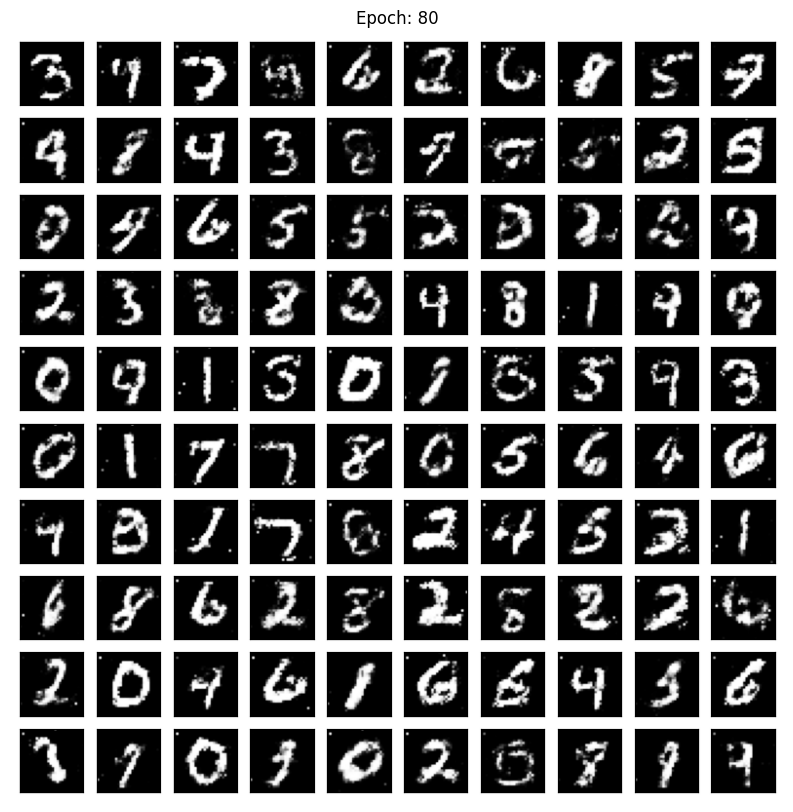

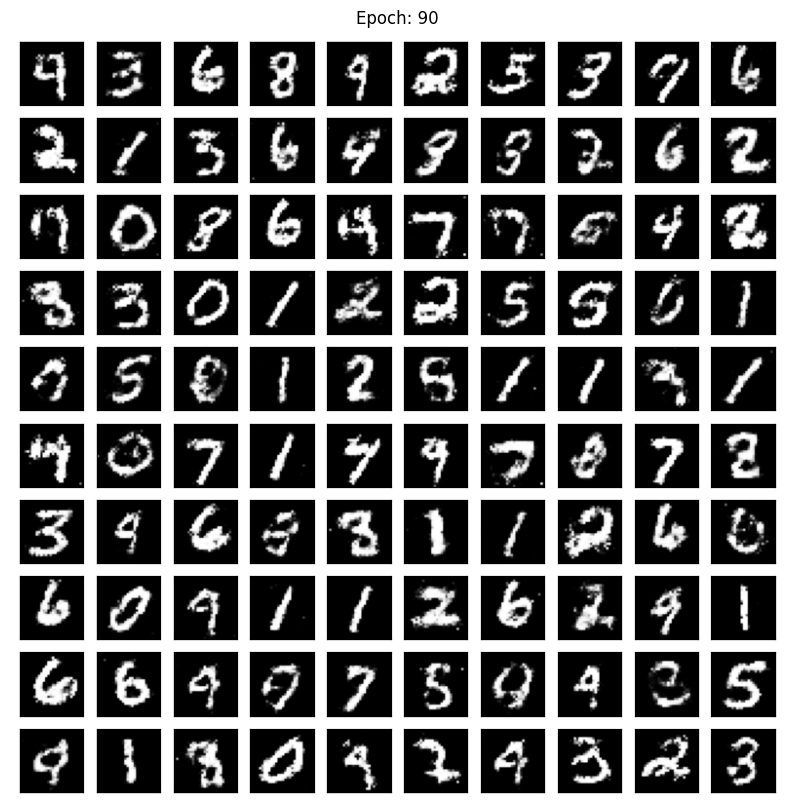

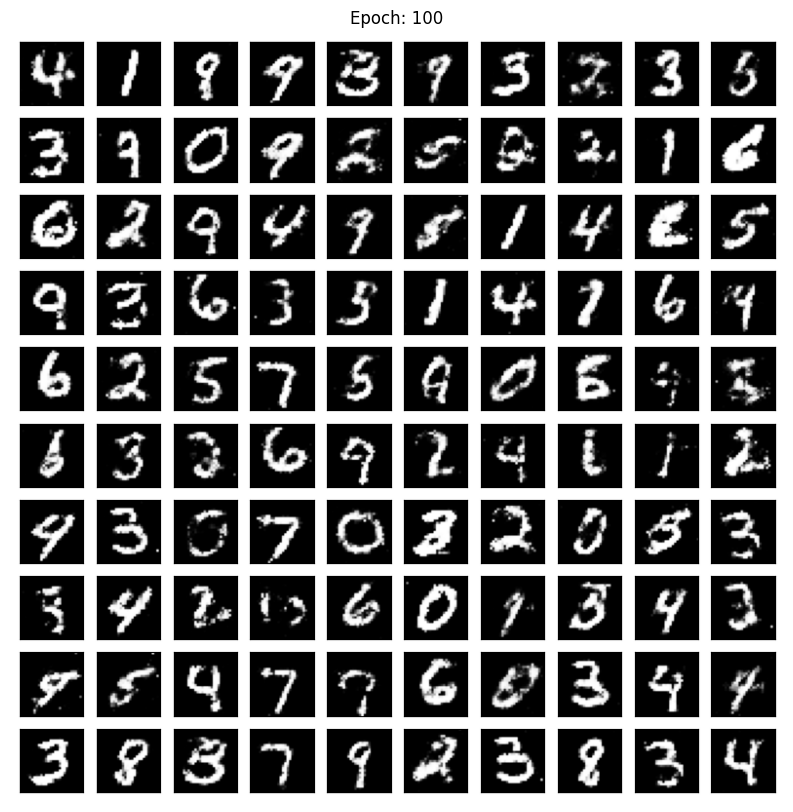

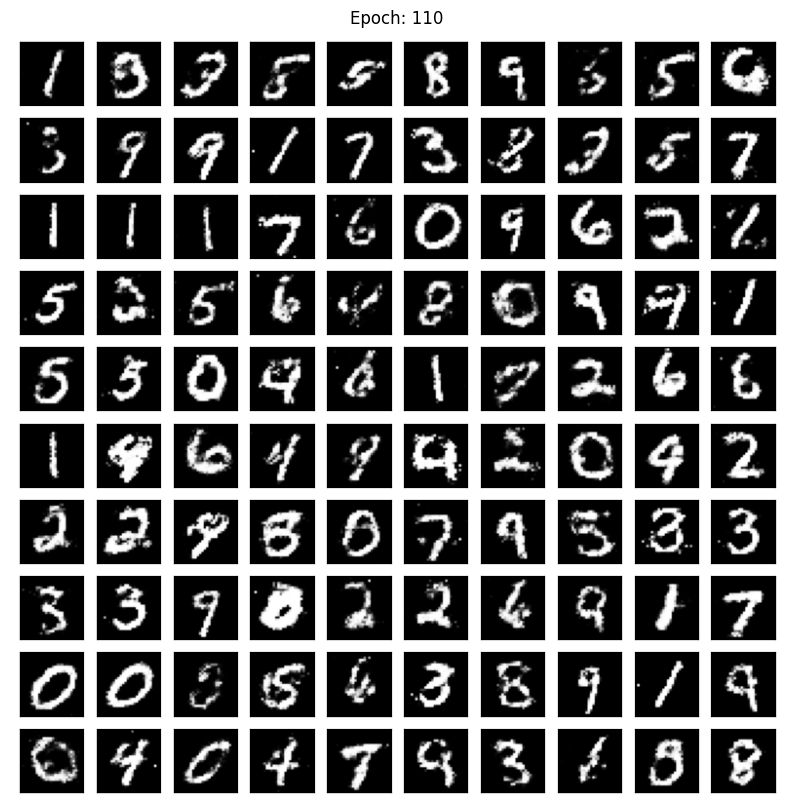

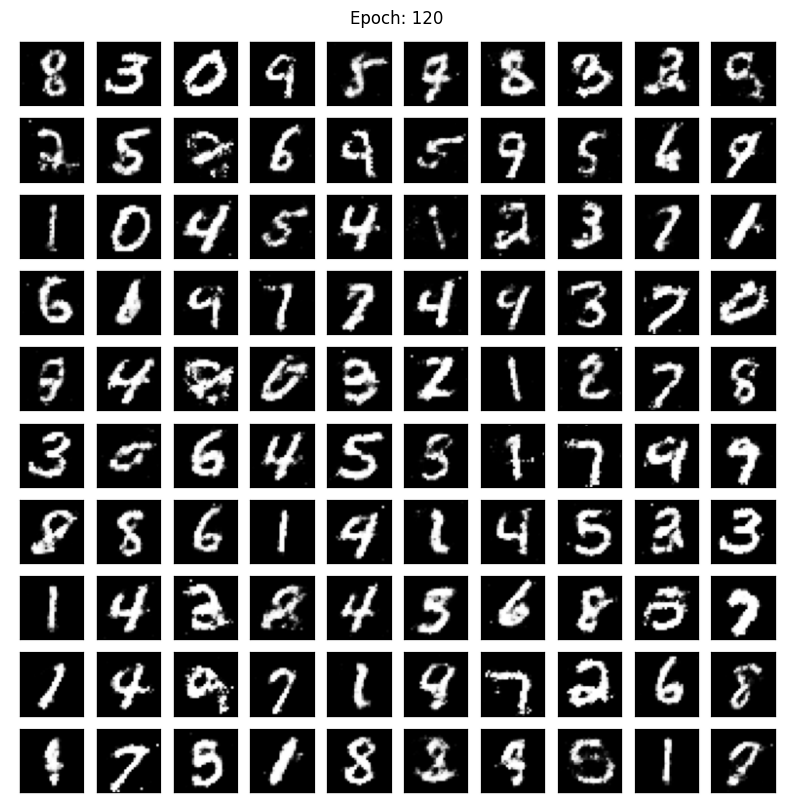

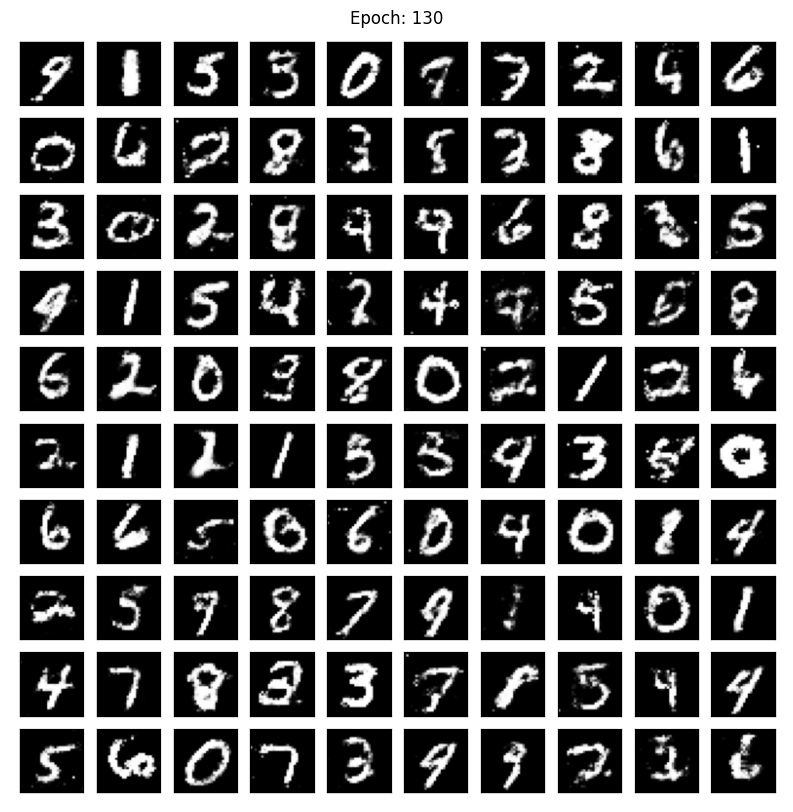

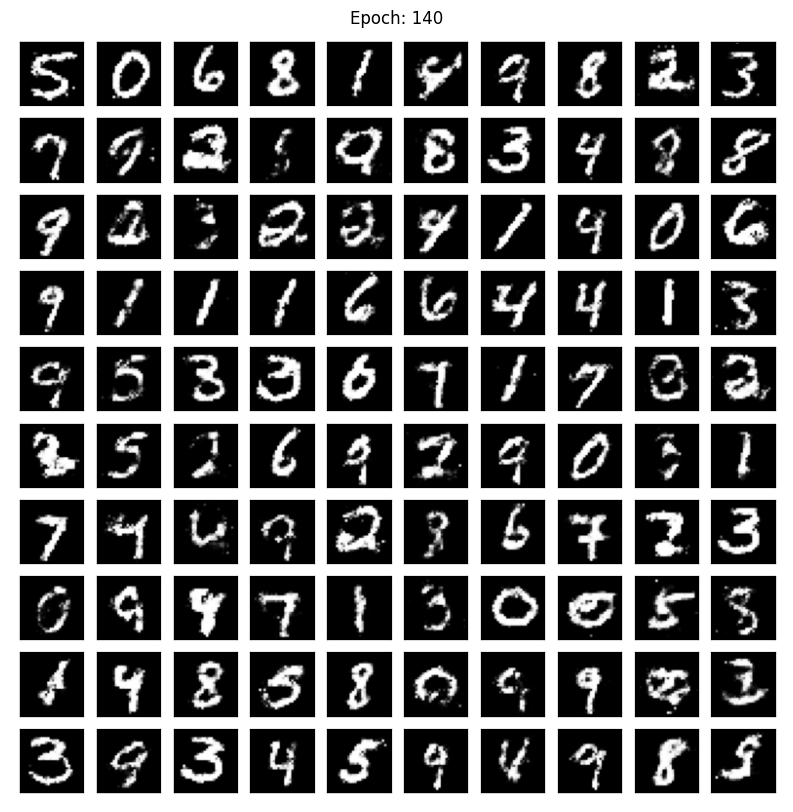

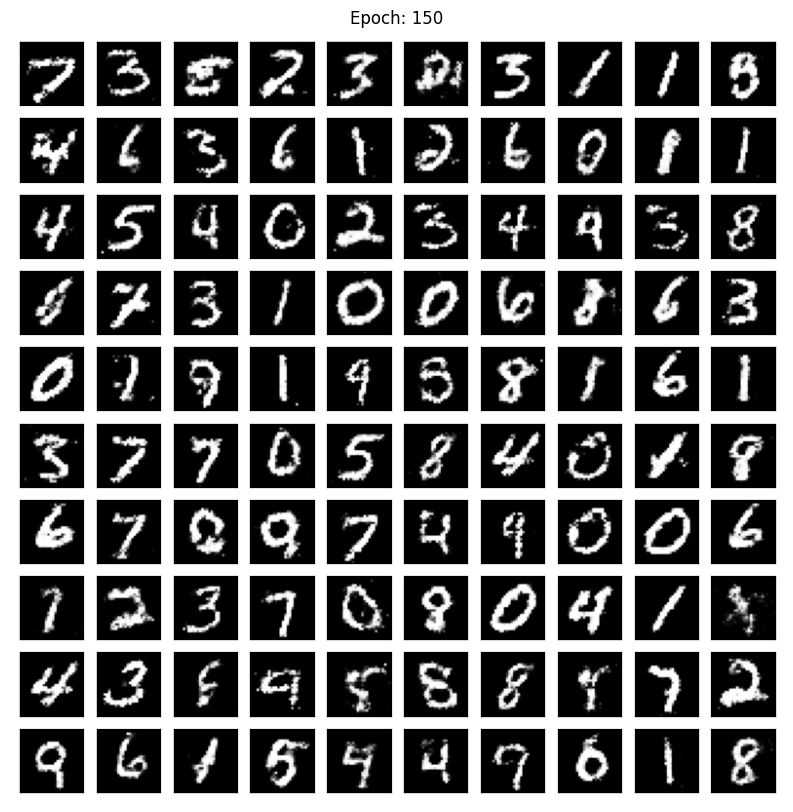

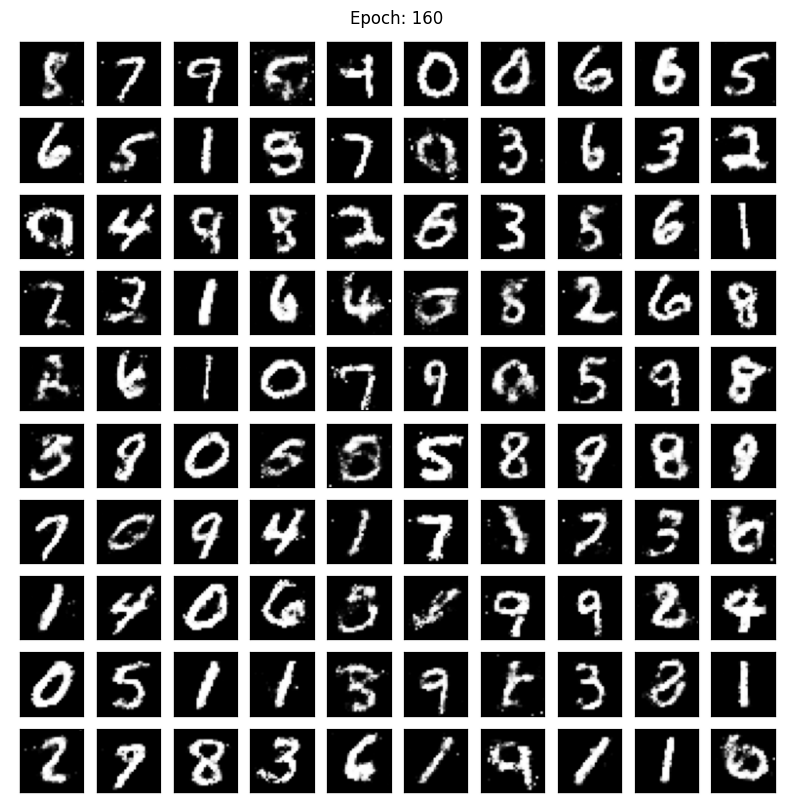

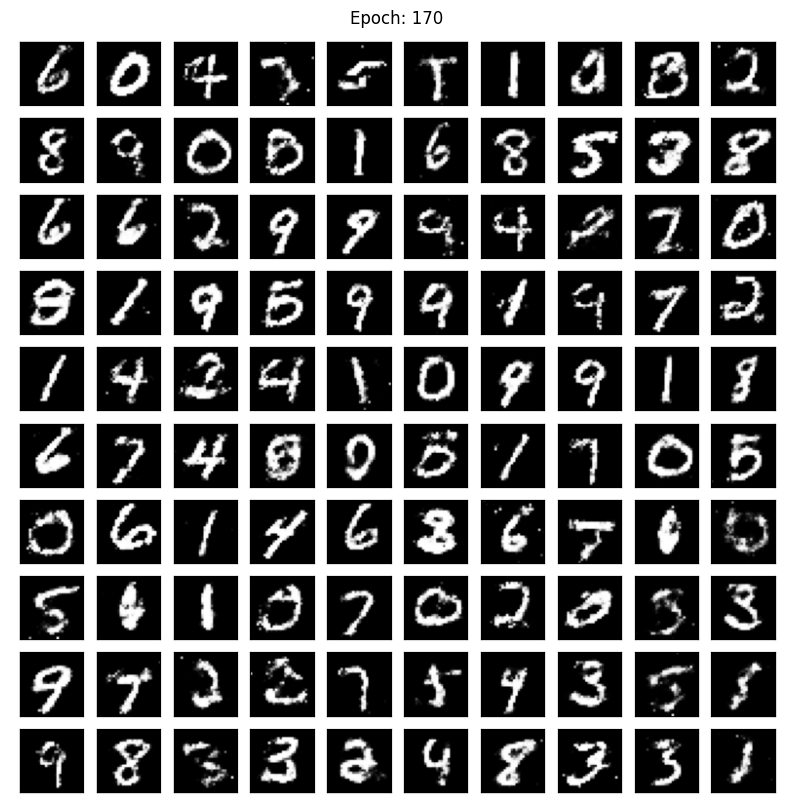

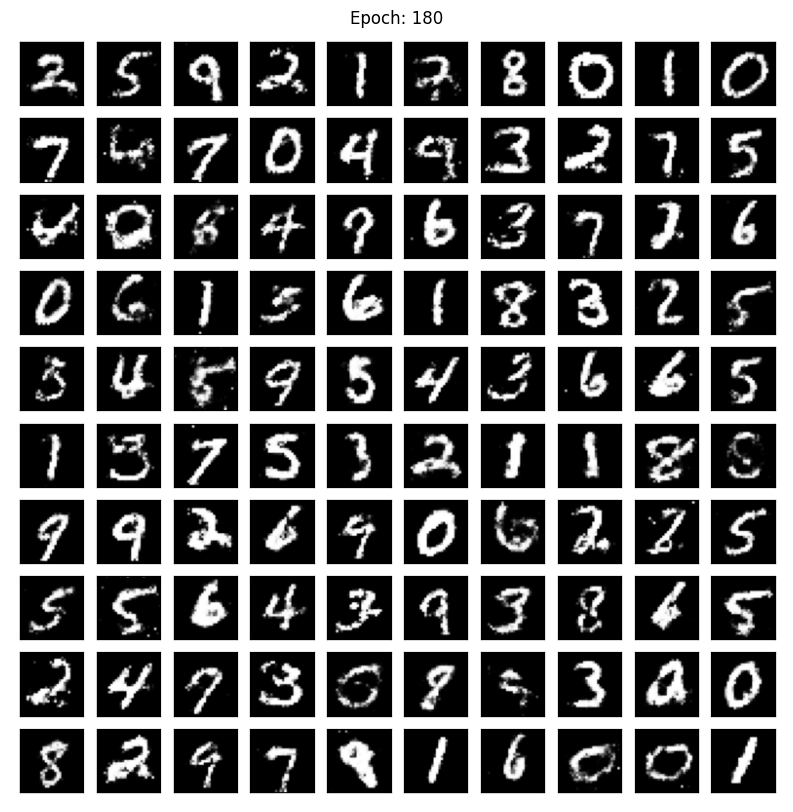

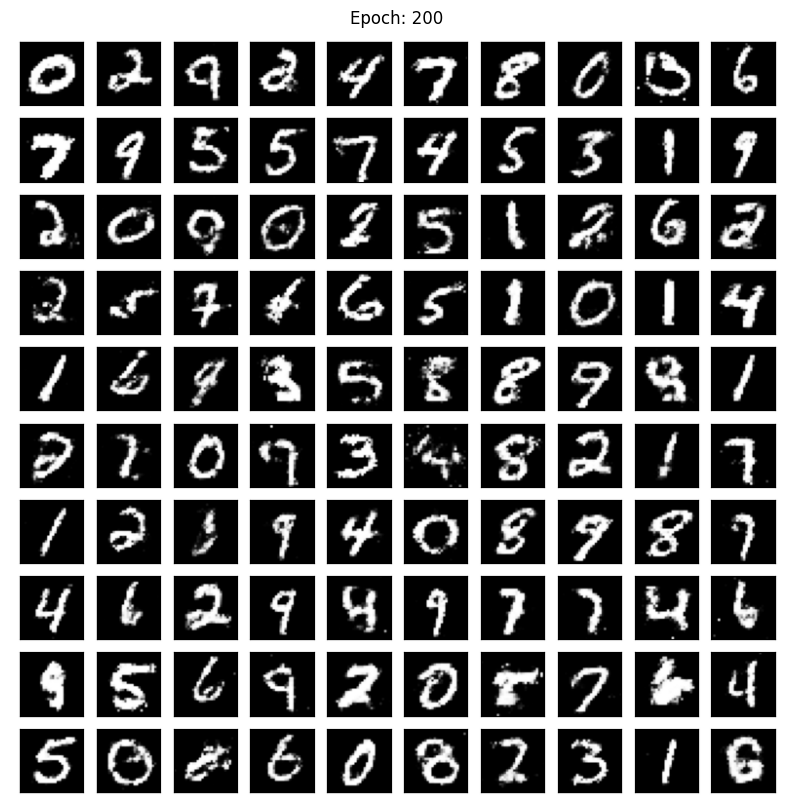

In [11]:
# display generated images
res_path = f'res/{folder_name_for_run}'
images = []

for name in glob(f'{res_path}/*.png'):
    epoch = name.split('_')[-1].split('.')[0]
    if epoch == 'final':
        epoch = -1
        
    images.append({'name': name, 'epoch': int(epoch), 'img': mpimg.imread(name)})

images = sorted(images, key=lambda x: x['epoch'])

for img in images:
    if img['epoch'] == -1:
        continue
    
    plt.figure(figsize=(10, 10))
    plt.imshow(img['img'])
    plt.title(f'Epoch: {img["epoch"]}')
    plt.axis('off')
    plt.show()
    

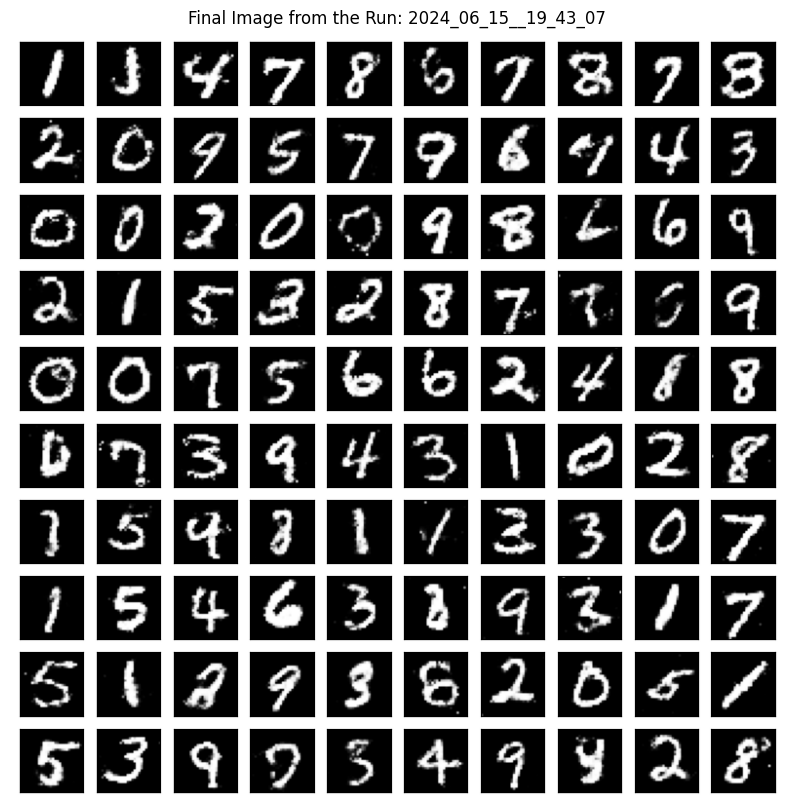

In [38]:
# final image
final_image = [img for img in images if img['epoch'] == -1][0]
plt.figure(figsize=(10, 10))
plt.imshow(final_image['img'])
plt.title(f'Final Image from the Run: {folder_name_for_run}')
plt.axis('off')
plt.show()

## 2a. Implement GAN with Convolutional architecture.

Convolutional neural networks (CNNs) have a better feature representation, unlike, fully connected layers. Hence, it is required here to modify your code to include CNNs in your script. For more information, check out this [tutorial](https://gucifer.github.io/mediator/feature/2021/08/11/GAN-evaluation-using-FID-and-IS.html). 

Similar to before, please report your training performance i.e. train loss as a figure and another figure containing a batch of generated images after training. You can plot one figure including and highlight the train loss using fully connected and CNN networks.

In [2]:
class GeneratorConvGan(nn.Module):
    def __init__(self, z_dim=100, img_channels=1, features_gen=64):
        super(GeneratorConvGan, self).__init__()
        self.gen = nn.Sequential(
            # Input: N x z_dim x 1 x 1
            nn.ConvTranspose2d(z_dim, features_gen * 8, 4, 1, 0),
            nn.BatchNorm2d(features_gen * 8),
            nn.ReLU(),
            # Size: (features_gen*8) x 4 x 4
            nn.ConvTranspose2d(features_gen * 8, features_gen * 4, 4, 2, 1),
            nn.BatchNorm2d(features_gen * 4),
            nn.ReLU(),
            # Size: (features_gen*4) x 8 x 8
            nn.ConvTranspose2d(features_gen * 4, features_gen * 2, 4, 2, 1),
            nn.BatchNorm2d(features_gen * 2),
            nn.ReLU(),
            # Size: (features_gen*2) x 16 x 16
            nn.ConvTranspose2d(features_gen * 2, features_gen, 4, 2, 1),
            nn.BatchNorm2d(features_gen),
            nn.ReLU(),
            # Size: features_gen x 32 x 32
            nn.ConvTranspose2d(features_gen, img_channels, 4, 2, 1),
            nn.Tanh()
            # Output: img_channels x 64 x 64
        )

    def forward(self, x):
        return self.gen(x)


class DiscriminatorConvGan(nn.Module):
    def __init__(self, img_channels=1, features_disc=64):
        super(DiscriminatorConvGan, self).__init__()
        self.disc = nn.Sequential(
            # Input: N x img_channels x 64 x 64
            nn.Conv2d(img_channels, features_disc, 4, 2, 1),
            nn.LeakyReLU(0.2),
            # Size: features_disc x 32 x 32
            nn.Conv2d(features_disc, features_disc * 2, 4, 2, 1),
            nn.BatchNorm2d(features_disc * 2),
            nn.LeakyReLU(0.2),
            # Size: (features_disc*2) x 16 x 16
            nn.Conv2d(features_disc * 2, features_disc * 4, 4, 2, 1),
            nn.BatchNorm2d(features_disc * 4),
            nn.LeakyReLU(0.2),
            # Size: (features_disc*4) x 8 x 8
            nn.Conv2d(features_disc * 4, features_disc * 8, 4, 2, 1),
            nn.BatchNorm2d(features_disc * 8),
            nn.LeakyReLU(0.2),
            # Size: (features_disc*8) x 4 x 4
            nn.Conv2d(features_disc * 8, 1, 4, 1, 0),
            nn.Sigmoid()
            # Output: 1 x 1 x 1
        )

    def forward(self, x):
        return self.disc(x).view(-1)

def train_discriminator_conv_gan(discriminator, generator, optimizer, criterion, real_images, noise):
    optimizer.zero_grad()
    real_preds = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0), 1).to(device)
    real_loss = criterion(real_preds, real_targets)

    fake_images = generator(noise)
    fake_targets = torch.zeros(fake_images.size(0), 1).to(device)
    fake_preds = discriminator(fake_images.detach())
    fake_loss = criterion(fake_preds, fake_targets)

    d_loss = real_loss + fake_loss
    d_loss.backward()
    optimizer.step()
    return d_loss

def train_generator_conv_gan(discriminator, generator, optimizer, criterion, noise):
    optimizer.zero_grad()
    fake_images = generator(noise)
    preds = discriminator(fake_images)
    targets = torch.ones(fake_images.size(0), 1).to(device)
    g_loss = criterion(preds, targets)
    g_loss.backward()
    optimizer.step()
    return g_loss

def save_generated_images_conv_gan(generator, epoch, z, folder_name_for_run, final_image=False, path="res"):
    with torch.no_grad():
        sample = generator(z).cpu().numpy()

    fig = plt.figure(figsize=(10, 10))
    gs = gridspec.GridSpec(10, 10)
    for j, sample_img in enumerate(sample):
        ax = plt.subplot(gs[j])
        ax.set_xticks([])
        ax.set_yticks([])
        plt.imshow(sample_img.reshape(64, 64), cmap='Greys_r')

    if not os.path.exists(path):
        os.makedirs(path)

    if not os.path.exists(f'{path}/{folder_name_for_run}'):
        os.makedirs(f'{path}/{folder_name_for_run}')

    if final_image:
        filename = os.path.join(path, f'{folder_name_for_run}/mnist_ConvGAN_{datetime.now().strftime("%Y%m%d%H%M%S")}_final.png')
    else:
        filename = os.path.join(path, f'{folder_name_for_run}/mnist_ConvGAN_{datetime.now().strftime("%Y%m%d%H%M%S")}_{str(epoch).zfill(7)}.png')

    plt.savefig(filename, bbox_inches='tight')
    plt.close()

In [3]:
# Hyperparameters
lr = 0.0002
batch_size = 128
image_size = 32
channels_img = 1
z_dim = 100
num_epochs = 5
features_gen = 64
features_disc = 64
folder_name_for_run = str(datetime.now().strftime("%Y_%m_%d__%H_%M_%S"))

hyperparameters = {'lr': lr, 'batch_size': batch_size, 'image_size': image_size, 'channels_img': channels_img,
                     'z_dim': z_dim, 'num_epochs': num_epochs, 'features_gen': features_gen, 'features_disc': features_disc}

In [4]:
loader = torch.utils.data.DataLoader(dataset_mnist, batch_size=batch_size, shuffle=True)

In [5]:
# Initialize models
gen = GeneratorConvGan(z_dim, channels_img, features_gen).to(device)
disc = DiscriminatorConvGan(channels_img, features_disc).to(device)

# Optimizers
opt_gen = optim.Adam(gen.parameters(), lr=lr, betas=(0.5, 0.999))
opt_disc = optim.Adam(disc.parameters(), lr=lr, betas=(0.5, 0.999))

In [6]:
start_time = datetime.now()
data_collector = []

for epoch in range(1, num_epochs + 1):
    for i, (real_images, _) in enumerate(loader):
        real_images = real_images.to(device)
        z = torch.randn(real_images.size(0), z_dim, 1, 1).to(device)

        # Train discriminator
        d_loss = train_discriminator_conv_gan(disc, gen, opt_disc, nn.BCELoss(), real_images, z)

        # Train generator more frequently
        for _ in range(2):  # Train generator twice as often
            z = torch.randn(real_images.size(0), z_dim, 1, 1).to(device)
            g_loss = train_generator_conv_gan(disc, gen, opt_gen, nn.BCELoss(), z)

        data_collector.append({'epoch': epoch, 'step': i, 'D_loss': d_loss.item(), 'G_loss': g_loss.item(), 'hyperparameters': hyperparameters})

        if i % 100 == 0:
            print(f'Epoch [{epoch}/{num_epochs}], Step [{i}/{len(loader)}], '
                  f'D Loss: {d_loss.item():.4f}, G Loss: {g_loss.item():.4f}')

    if epoch % 10 == 0:
        print(f'--- Saving images at Epoch [{epoch}] ---')
        z = torch.randn(100, z_dim, 1, 1).to(device)
        save_generated_images_conv_gan(gen, epoch, z, folder_name_for_run)

end_time = datetime.now()
print(f'Training took : {end_time - start_time}')

# Save final generated images
z = torch.randn(100, z_dim, 1, 1).to(device)
save_generated_images_conv_gan(gen, num_epochs, z, folder_name_for_run, final_image=True)

# Save data collector
if not os.path.exists('results'):
    os.makedirs('results')
with open('results/data_collector.json', 'w') as f:
    json.dump(data_collector, f, indent=4)

/home/sanxchep/DataspellProjects/atdl/venv/lib/python3.9/site-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


RuntimeError: Calculated padded input size per channel: (1 x 1). Kernel size: (4 x 4). Kernel size can't be greater than actual input size

In [ ]:
#setup convolutional generator

In [ ]:
#etup convolutional discriminator

In [ ]:
#training loop

In [ ]:
#plot losses and generated images with the convolutional GAN

## 2b. now reimplement this with FASHION-MNIST with a convolutinal architecture

## 3. Conditional GAN (cGAN)

Vanilla GANs produce synthetic images by drawing a random vector from latent space. However, we may condition the GAN to additional information, namely, a class label e.g. label  "0" in MNIST. This requires to additionally input the label to G and D networks along with random vector drawn from latent space. You may use this [cGAN](https://learnopencv.com/conditional-gan-cgan-in-pytorch-and-tensorflow/) tutorial to implement a cGAN based on the convolutional archiecture you've implemented before. Furthermore, MNIST should be used in this task.

In [ ]:
#generator and discriminator 

In [ ]:
#define training step for generator 

#define training step for discriminator

In [ ]:
#training loop


In [ ]:
#plot looses and generated images along wth their conditions 